In [1]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from regression_utils import *
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
# convention followed in relation to scikit documentation 
# y = countryQuantity 
# y1 = countryQuantityTrain
# Y = countryQuantityTest
# y_pred = countryQuantityPredict

# X = years 
# X1 = yearsTrain
# x_mis = yearsTest
# x = yearsPredict

# c = combinedZip

In [3]:
#reading data from csv 
df = pd.read_csv('datasets_12603_17232_Life Expectancy Data.csv')
df.fillna(df.mean(), inplace=True)

# change here 
country = 'Germany'

# extract dataframe for selected country 
countryDataFrame = countryDF(country, df)   

# Feature 1 
countryQuantity = 'Life expectancy'

split = random.randrange(1,10)/10
print('Train:Test split is: ', split, ':',round(1-split,1))
# train test split
randomRowsTrain = countryDataFrame.sample(frac=split)
randomRowsTest = countryDataFrame.loc[~countryDataFrame.index.isin(randomRowsTrain.index)]

# train test split row numbers (to keep record of train test split in order to aid plotting)
rowTrain = list(randomRowsTrain['Year'].get_values())
rowTest = list(randomRowsTest['Year'].get_values())

# extract data (countryQuantity) from dataframe depending on the train test split 
countryQuantityTrain = columnExtractor(randomRowsTrain, countryQuantity)
countryQuantityTest = columnExtractor(randomRowsTest, countryQuantity)

# extract data (allFeatures) from dataframe depending on the train test split 
desiredFeatures = ['Year', 'Total expenditure', 'BMI']
allFeaturesTrain = variableColumnExtractor(randomRowsTrain, desiredFeatures)
allFeaturesTest = variableColumnExtractor(randomRowsTest, desiredFeatures)

Train:Test split is:  0.4 : 0.6


In [4]:
##Gaussian regression analysis 
lengthScale = np.random.randint(50) 
kernel = C(1.0, (1e-3, 1e3)) * RBF(lengthScale, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

gp.fit(allFeaturesTrain, countryQuantityTrain)
countryQuantityPredict, sigma = gp.predict(allFeaturesTest, return_std=True)
print(countryQuantityPredict)

[86.94354054 85.75143418 78.65030043 80.02436693 80.05764808 79.73137997
 78.04413147 76.94286364 75.6611091  73.99850143]


In [5]:
##Linear regression analysis 
regr = linear_model.LinearRegression()
regr.fit(allFeaturesTrain, countryQuantityTrain)

countryQuantityPredictLR = regr.predict(allFeaturesTest)
print(countryQuantityPredictLR)

[83.65861517 85.81763538 82.88135174 79.31213508 79.20328019 79.09038177
 78.80271644 78.57302923 78.33380263 78.15817198]


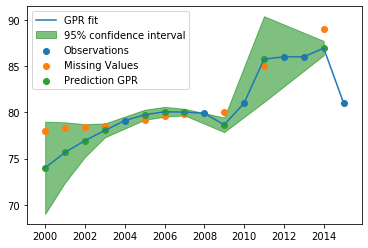

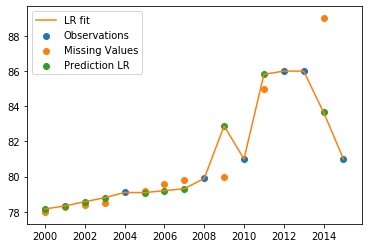

In [6]:
predictValLR = list(zip(rowTest, list(countryQuantityPredictLR)))
predictValLR.sort()

predictValGPR = list(zip(rowTest, list(countryQuantityPredict)))
predictValGPR.sort()

trainVal = list(zip(rowTrain, list(countryQuantityTrain)))
trainVal.sort()

valLR = trainVal + predictValLR
valLR.sort(key = lambda x: x[0]) 

valGPR = trainVal + predictValGPR
valGPR.sort(key = lambda x: x[0])

years, LR = zip(*valLR)
years, GPR = zip(*valGPR)

plt.plot(years, GPR,color='#1f77b4',label='GPR fit')
plt.fill_between(list(rowTest), (list(countryQuantityPredict)-2*sigma), (countryQuantityPredict+2*sigma), 
                     color='green',alpha=0.5,label='95% confidence interval')
plt.scatter(rowTrain,countryQuantityTrain,label='Observations')
plt.scatter(rowTest,countryQuantityTest,label='Missing Values')
plt.scatter(rowTest,countryQuantityPredict,label='Prediction GPR') 
plt.legend()
plt.show()

plt.plot(years, LR,color='#ff7f0e',label='LR fit')
plt.scatter(rowTrain,countryQuantityTrain,label='Observations')
plt.scatter(rowTest,countryQuantityTest,label='Missing Values')
plt.scatter(rowTest,countryQuantityPredictLR,label='Prediction LR')
plt.legend()
plt.show()

GPR prediction  [74.0, 75.7, 76.9, 78.0, 79.1, 79.7, 80.1, 80.0, 79.9, 78.7, 81.0, 85.8, 86.0, 86.0, 86.9, 81.0]
groundTruth values  [78.  78.3 78.4 78.5 79.1 79.2 79.6 79.8 79.9 80.  81.  85.  86.  86.
 89.  81. ]
LR prediction  [78.2, 78.3, 78.6, 78.8, 79.1, 79.1, 79.2, 79.3, 79.9, 82.9, 81.0, 85.8, 86.0, 86.0, 83.7, 81.0]


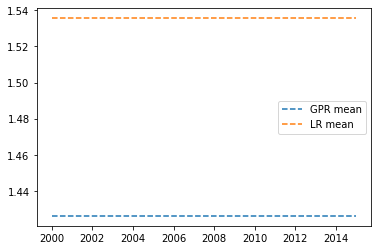

In [9]:
# error computation for GPR 

GPR = [round(float(i),1) for i in list(GPR)]
print('GPR prediction ',GPR)
groundTruth = countryDataFrame[countryQuantity].get_values()[::-1]
print('groundTruth values ',groundTruth)

errorGPR = np.sqrt(mean_squared_error(groundTruth, GPR))

# error computation for LR 

LR = [round(float(i),1) for i in list(LR)]
print('LR prediction ',LR) 

errorLR = np.sqrt(mean_squared_error(groundTruth, LR))

plt.plot(years, np.ones((len(years),1))*np.mean(errorGPR.T), '--', color='#1f77b4',label='GPR mean')
#plt.plot(rowTest, errorGPR, color='#ff7f0e',label='GPR') 
plt.plot(years, np.ones((len(years),1))*np.mean(errorLR.T), '--', color='#ff7f0e',label='LR mean')
#plt.plot(rowTest, errorLR, color='#1f77b4',label='LR')
plt.legend()

plt.show()

#go with rmse for outliers 
#try using normalization

In [ ]:
#https://yugeten.github.io/posts/2019/09/GP/
#https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html
#https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-download-auto-examples-gaussian-process-plot-gpr-co2-py
#https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/statistical_inference/supervised_learning.html
